In [1]:
using Pkg
Pkg.update()
Pkg.add(["LazIO", "GeoDataFrames", "GeoFormatTypes", "Extents", "GeoInterface", "GeoInterfaceRecipes", "GeoArrays", "GeoArrayOps", "SpaceLiDAR", "Plots", "GeoStatsSolvers"])
Pkg.add(url="https://github.com/Deltares/PointCloudRasterizers.jl")

    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/Deltares/PointCloudRasterizers.jl`
  No Changes to `~/code/Project.toml`
  No Changes to `~/code/Manifest.toml`
   Resolving package versions...
  No Changes to `~/code/Project.toml`
  No Changes to `~/code/Manifest.toml`
    Updating git-repo `https://github.com/Deltares/PointCloudRasterizers.jl`
   Resolving package versions...
  No Changes to `~/code/Project.toml`
  No Changes to `~/code/Manifest.toml`


# LiDAR pointclouds
In this notebook we open a small LiDAR pointcloud in the .laz format and try to classify the ground surface.

In [2]:
using LazIO, PointCloudRasterizers, GeoInterface, GeoInterfaceRecipes, GeoDataFrames, Plots, DataFrames, GeoFormatTypes, GeoArrayOps, GeoArrays, Statistics, GeoStatsSolvers

[ Info: Precompiling PointCloudRasterizers [971589f2-82d2-11e9-1393-93ab095f3ec7]


In [3]:
fn = "vlieland.laz"
ds = LazIO.open(fn)

LazIO Dataset of vlieland.laz with 535806 points of version 1.


In [4]:
GeoInterfaceRecipes.@enable_geo_plots LazIO.Dataset
GeoInterfaceRecipes.@enable_geo_plots LazIO.Point

GeoInterface.ncoord(::MultiPointTrait, ::LazIO.Dataset) = 2
GeoInterface.nfeature(::FeatureCollectionTrait, ds::LazIO.Dataset{T}) where T = length(ds)
GeoInterface.getfeature(::FeatureCollectionTrait, ds::LazIO.Dataset{T}) where T = ds
GeoInterface.geometry(feat::LazIO.Point) = feat.geometry

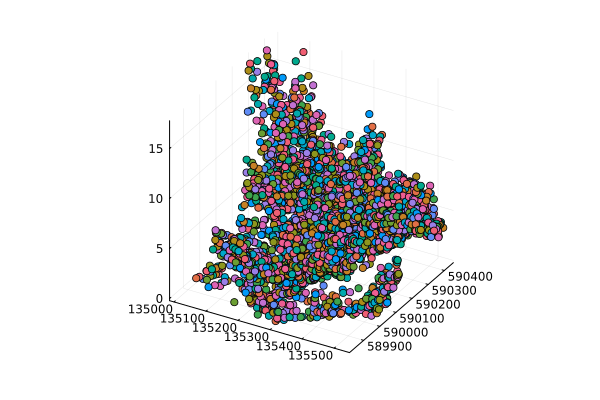

In [5]:
plot(collect(ds)[begin:100:end])

In [6]:
df = DataFrame(ds)

535806×13 DataFrame
    Row │ geometry                       intensity  return_number  number_of_r ⋯
        │ SArray…                        UInt16     UInt8          UInt8       ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ [1.35454e5, 5.89999e5, 0.376]        190              1              ⋯
      2 │ [1.35455e5, 5.8999e5, 0.472]         500              1
      3 │ [1.35452e5, 5.89998e5, 0.457]        503              1
      4 │ [1.3545e5, 5.9e5, 0.347]             694              1
      5 │ [1.35454e5, 5.8999e5, 0.562]         497              1              ⋯
      6 │ [1.35453e5, 5.89989e5, 0.475]        327              1
      7 │ [1.35449e5, 5.89999e5, 0.446]        628              1
      8 │ [135456.0, 5.89982e5, 0.561]         295              1
      9 │ [1.3545e5, 5.89996e5, 0.413]         630              1              ⋯
     10 │ [1.35449e5, 5.89998e5, 0.34]         239              1
     11 │ [1.35448e5, 5.89998e5, 0.448]        330              1
   ⋮    │               ⋮                    ⋮            ⋮                ⋮   ⋱
 535797 │ [1.35528e5, 5.904e5, 3.081]         1272              1
 535798 │ [1.35531e5, 5.90396e5, 3.365]       1147              1              ⋯
 535799 │ [1.35531e5, 5.90398e5, 3.356]       1223              1
 535800 │ [1.3553e5, 5.90398e5, 3.109]        1100              1
 535801 │ [1.3553e5, 5.90399e5, 2.948]        1221              1
 535802 │ [1.3553e5, 5.904e5, 2.966]          1169              1              ⋯
 535803 │ [1.3553e5, 5.904e5, 2.934]          1219              1
 535804 │ [1.35531e5, 590400.0, 2.913]        1275              1
 535805 │ [1.35531e5, 5.90402e5, 2.857]       1066              1
 535806 │ [1.35531e5, 5.90402e5, 2.811]       1233              1              ⋯
                                              10 columns and 535785 rows omitted

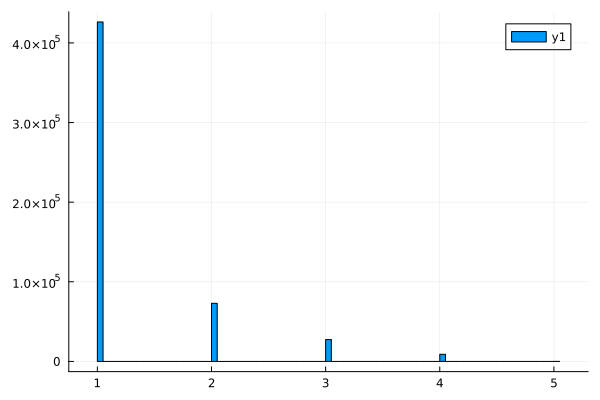

In [7]:
histogram(df.number_of_returns)

In [8]:
GeoDataFrames.write("vlieland.gpkg", df)

"vlieland.gpkg"

In [9]:
round(Int, filesize("vlieland.laz") / filesize("vlieland.gpkg") * 100)

7

# Classifying the pointcloud
Let's classify the pointcloud, specifically to find the terrain.

In [48]:
idx = PointCloudRasterizers.index(ds, (1, 1), crs=GeoFormatTypes.EPSG(28992))

PointCloudIndex of LazIO.Dataset{0x01}


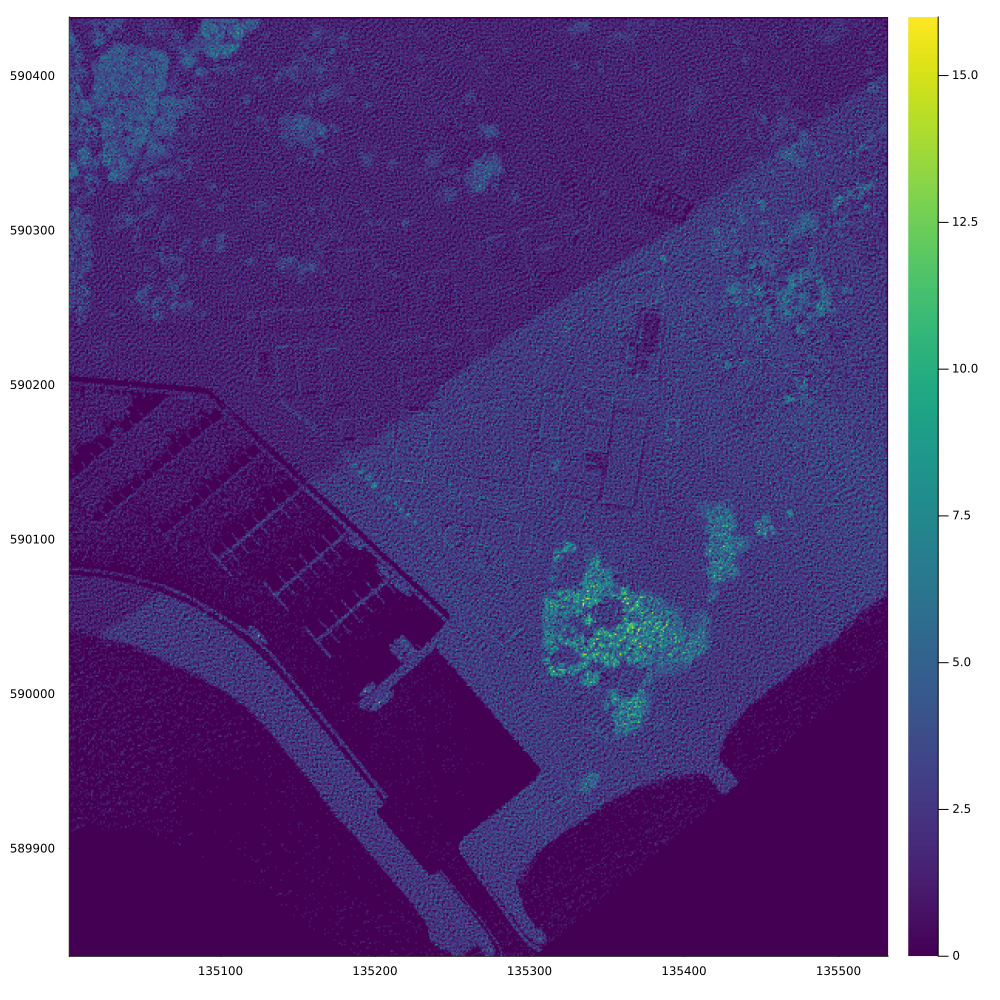

In [11]:
plot(idx.counts, size=(1000,1000))

In [14]:
last_return(p) = p.return_number == p.number_of_returns

last_return (generic function with 1 method)

In [49]:
filter!(idx, last_return)

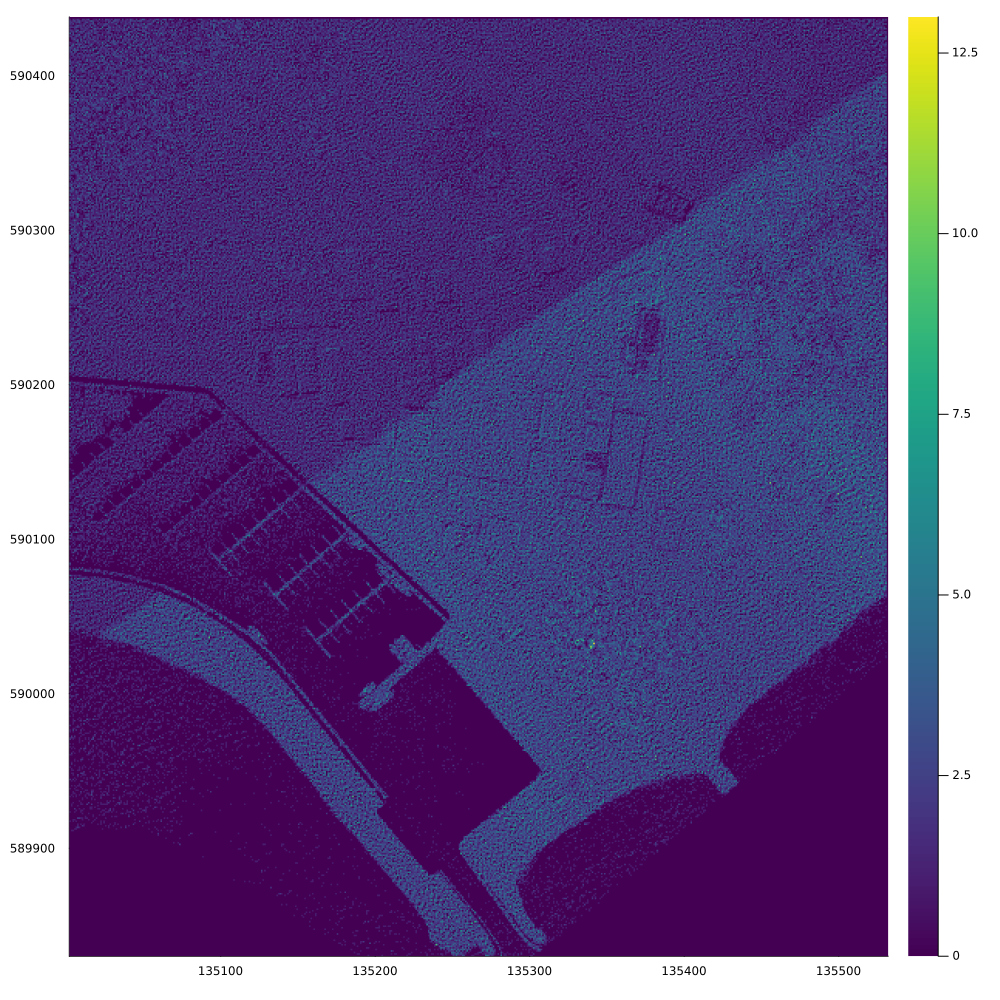

In [16]:
plot(idx.counts, size=(1000,1000))

In [17]:
min_raster = reduce(idx, reducer=minimum)

530x608x1 Array{Union{Missing, Float64}, 3} with AffineMap([0.9999924528302147 0.0; 0.0 0.9999046052632222], [135002.003, 589830.057]) and CRS PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]]

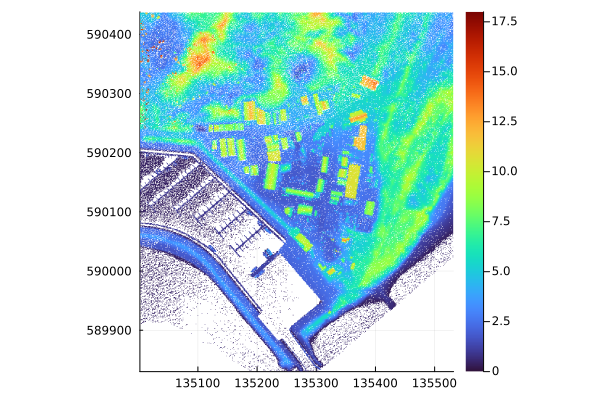

In [47]:
plot(min_raster, c=:turbo, clim=(0,18))

In [19]:
max_raster, windows = pmf(reshape(GeoArrays.coalesce(min_raster, NaN), size(min_raster)[1:2]))

([NaN NaN … 4.845000000000001 NaN; NaN NaN … NaN NaN; … ; NaN NaN … 3.216 NaN; NaN NaN … NaN NaN], [NaN NaN … 9.0 NaN; NaN NaN … NaN NaN; … ; NaN NaN … 0.0 NaN; NaN NaN … NaN NaN])

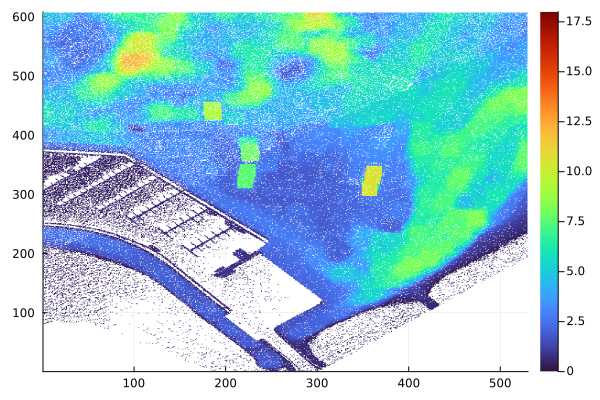

In [50]:
heatmap(max_raster', c=:turbo, clim=(0,18))

In [21]:
?pmf

search: pmf PROGRAM_FILE PKGMODE_MANIFEST pointer_from_objref



```
B, flags = pmf(A; ωₘ, slope, dhₘ, dh₀, cellsize)
```

Applies the progressive morphological filter by *Zhang et al. (2003)* [^zhang2003] to `A`.

# Output

  * `B::Array{T,2}` Maximum allowable values
  * `flags::Array{Float64,2}` A sized array with window sizes if filtered, zero if not filtered.

Afterwards, one can retrieve the resulting mask for `A` by `A .<= B` or `flags .== 0.`.

# Arguments

  * `A::Array{T,2}` Input Array
  * `ωₘ::Float64=20.` Maximum window size [m]
  * `slope::Float64=0.01` Terrain slope [m/m]
  * `dhₘ::Float64=2.5` Maximum elevation threshold [m]
  * `dh₀::Float64=0.2` Initial elevation threshold [m]
  * `cellsize::Float64=1.` Cellsize in [m]

[^zhang2003]: Zhang, Keqi, Shu-Ching Chen, Dean Whitman, Mei-Ling Shyu, Jianhua Yan, and Chengcui Zhang. “A Progressive Morphological Filter for Removing Nonground Measurements from Airborne LIDAR Data.” IEEE Transactions on Geoscience and Remote Sensing 41, no. 4 (2003): 872–82. [https://doi.org/10.1109/TGRS.2003.810682](https://doi.org/10.1109/TGRS.2003.810682).


In [45]:
max_raster2, _ = pmf(reshape(GeoArrays.coalesce(min_raster, NaN), size(min_raster)[1:2]),slope=0.1, ωₘ=35., dh₀=1.0, dhₘ=10.)

([NaN NaN … 5.107 NaN; NaN NaN … NaN NaN; … ; NaN NaN … 3.216 NaN; NaN NaN … NaN NaN], [NaN NaN … 0.0 NaN; NaN NaN … NaN NaN; … ; NaN NaN … 0.0 NaN; NaN NaN … NaN NaN])

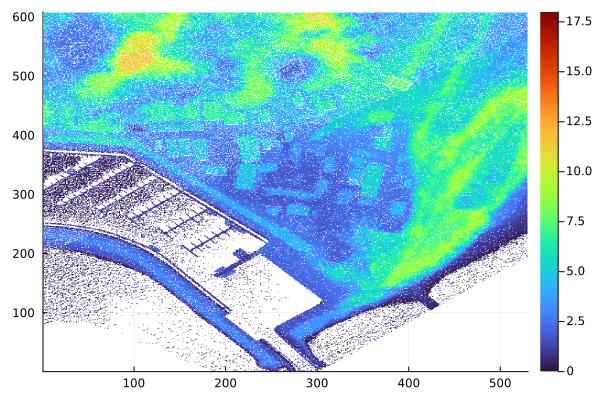

In [46]:
heatmap(max_raster2', c=:turbo, clim=(0,18))

In [44]:
terrain(p, r) = GeoInterface.z(p) <= r

terrain (generic function with 1 method)

In [51]:
filter!(idx, GeoArray(max_raster2, idx.counts.f, idx.counts.crs), terrain)

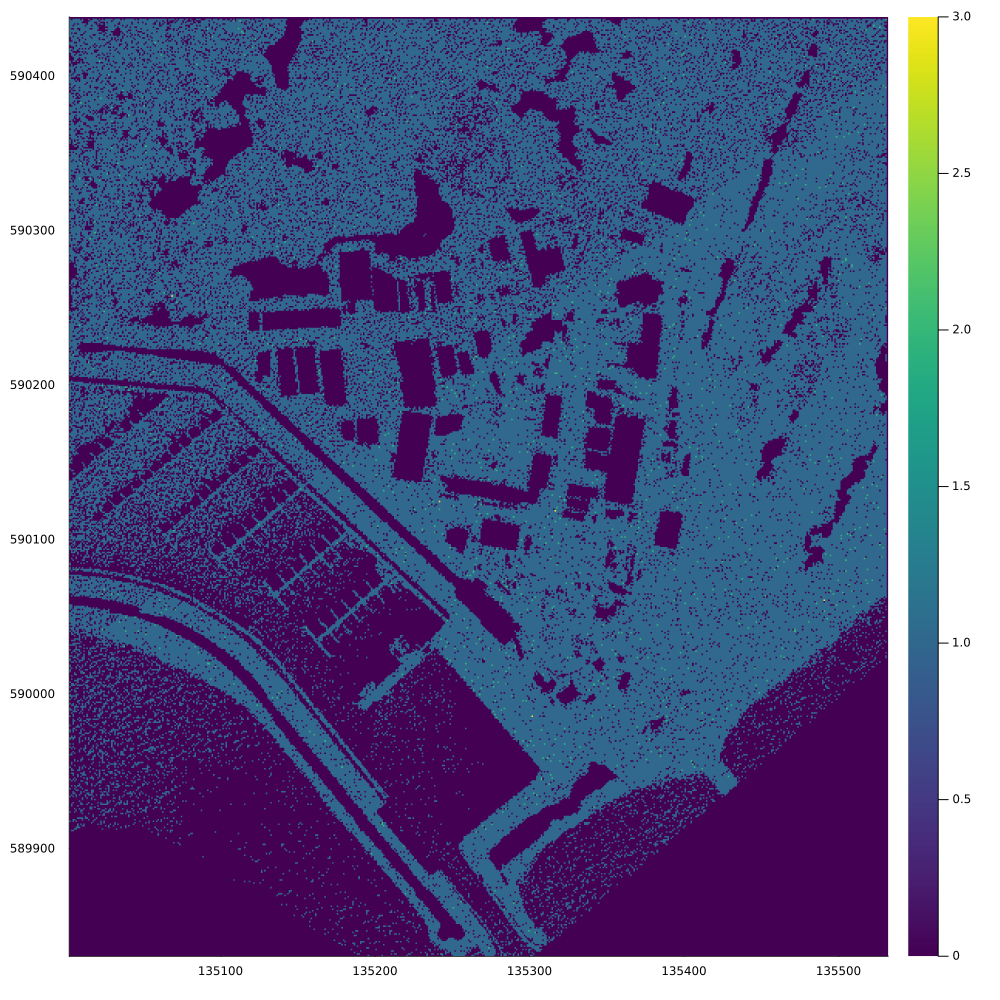

In [52]:
plot(idx.counts, size=(1000,1000))

In [53]:
dtm = reduce(idx, reducer=mean)

530x608x1 Array{Union{Missing, Float64}, 3} with AffineMap([0.9999924528302147 0.0; 0.0 0.9999046052632222], [135002.003, 589830.057]) and CRS PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]]

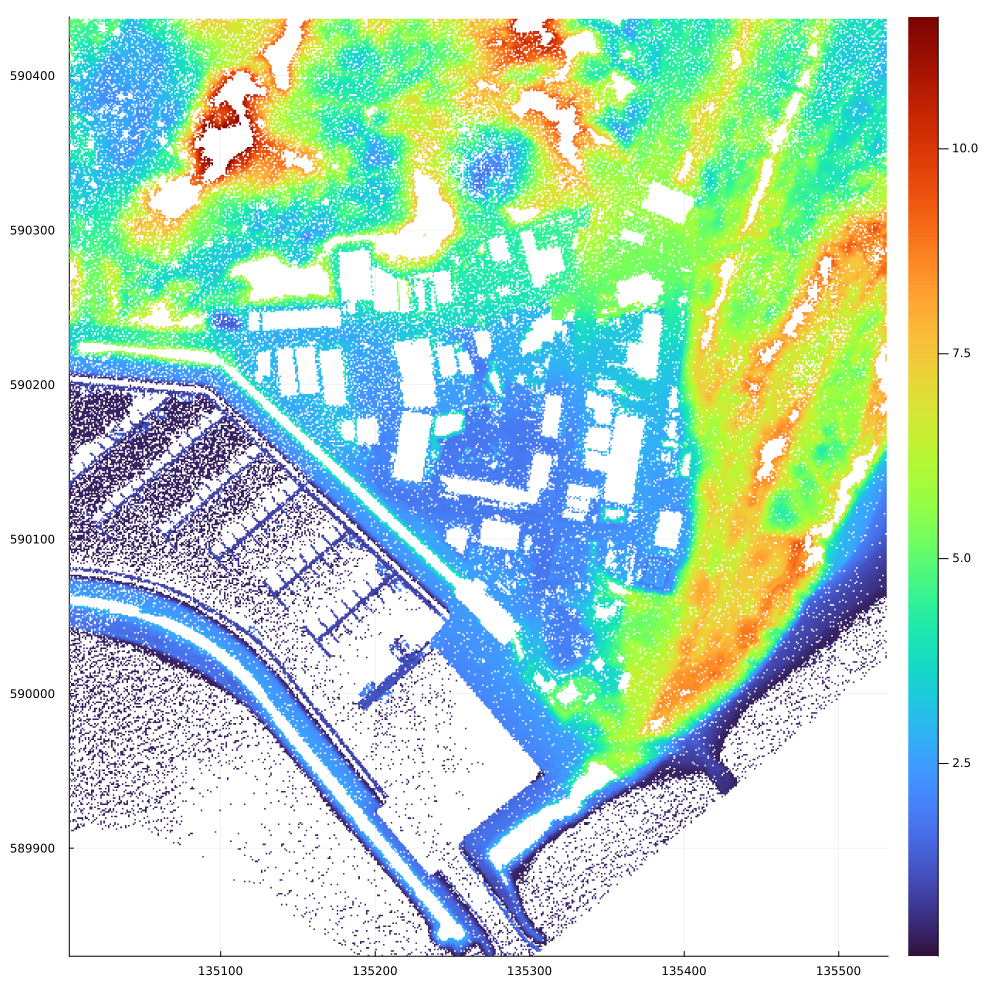

In [54]:
plot(dtm, size=(1000,1000), c=:turbo)

LoadError: type NamedTuple has no field domain